**Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

[nltk_data] Downloading package stopwords to C:\Users\LENOVO
[nltk_data]     IDEAPAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Đọc bộ dữ liệu**

In [2]:
dataset_path = 'Twitter_Data.csv'
df = pd.read_csv(dataset_path)
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


**Xóa missing data**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [4]:
df = df.dropna()

**Xây dựng hàm chuẩn hóa văn bản**

In [5]:
def text_normalize(text):
    # Lowercasing
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^rt[\s]+', '', text)

    # Hyperlink removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)

    # Stemming
    stemmer = SnowballStemmer("english")
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text


**Khởi tạo tf-idf vectorizer**

In [6]:
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()

**Thêm bias vào X**

In [7]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate((intercept, X), axis=1)

**One-hot encoding label**

In [8]:
n_classes = df['category'].nunique()
n_sample = df['category'].size

y = df['category'].to_numpy() + 1
y = y.astype(np.uint8)
y_encoded = np.array([np.zeros(n_classes) for i in range(n_sample)])
y_encoded[np.arange(n_sample), y] = 1

**Chia bộ train, val, test**

In [9]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X_b, y_encoded, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

**Cài đặt các hàm quan trọng**

In [10]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def compute_loss(y, y_hat):
    return -np.sum(y * np.log(y_hat)) / y.size

def prefict(X, theta):
    z = X @ theta
    return softmax(z)

def compute_gradient(X, y, y_hat):
    return X.T @ (y_hat - y) / y.size

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = prefict(X, theta)
    return np.mean(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))

**Khai báo các siêu tham số và khởi tạo weights**

In [11]:
lr = 0.1
epochs = 200
batch_size = X_train.shape[0]
n_features = X_train.shape[1]

np.random.seed(random_state)
theta = np.random.uniform(size=(n_features, n_classes))

**Huấn luyện mô hình**

In [12]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    train_batch_loss = []
    val_batch_loss = []
    train_batch_accs = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        y_hat = prefict(X_batch, theta)
        gradient = compute_gradient(X_batch, y_batch, y_hat)
        theta = update_theta(theta, gradient, lr)

        train_batch_loss.append(compute_loss(y_batch, y_hat))
        train_batch_accs.append(compute_accuracy(X_batch, y_batch, theta))

        val_pred = prefict(X_val, theta)
        val_batch_loss.append(compute_loss(y_val, val_pred))
        val_batch_accs.append(compute_accuracy(X_val, y_val, theta))

    train_losses.append(np.mean(train_batch_loss))
    val_losses.append(np.mean(val_batch_loss))
    train_accs.append(np.mean(train_batch_accs))
    val_accs.append(np.mean(val_batch_accs))

    print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accs[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Val Accuracy: {val_accs[-1]:.4f}')


Epoch 1/200 - Train Loss: 0.3772 - Train Accuracy: 0.3632 - Val Loss: 0.3763 - Val Accuracy: 0.3672
Epoch 2/200 - Train Loss: 0.3769 - Train Accuracy: 0.3645 - Val Loss: 0.3759 - Val Accuracy: 0.3682
Epoch 3/200 - Train Loss: 0.3765 - Train Accuracy: 0.3656 - Val Loss: 0.3756 - Val Accuracy: 0.3692
Epoch 4/200 - Train Loss: 0.3762 - Train Accuracy: 0.3668 - Val Loss: 0.3753 - Val Accuracy: 0.3703
Epoch 5/200 - Train Loss: 0.3759 - Train Accuracy: 0.3680 - Val Loss: 0.3749 - Val Accuracy: 0.3718
Epoch 6/200 - Train Loss: 0.3756 - Train Accuracy: 0.3690 - Val Loss: 0.3746 - Val Accuracy: 0.3731
Epoch 7/200 - Train Loss: 0.3753 - Train Accuracy: 0.3701 - Val Loss: 0.3743 - Val Accuracy: 0.3744
Epoch 8/200 - Train Loss: 0.3750 - Train Accuracy: 0.3714 - Val Loss: 0.3740 - Val Accuracy: 0.3749
Epoch 9/200 - Train Loss: 0.3747 - Train Accuracy: 0.3726 - Val Loss: 0.3737 - Val Accuracy: 0.3763
Epoch 10/200 - Train Loss: 0.3744 - Train Accuracy: 0.3735 - Val Loss: 0.3735 - Val Accuracy: 0.3770

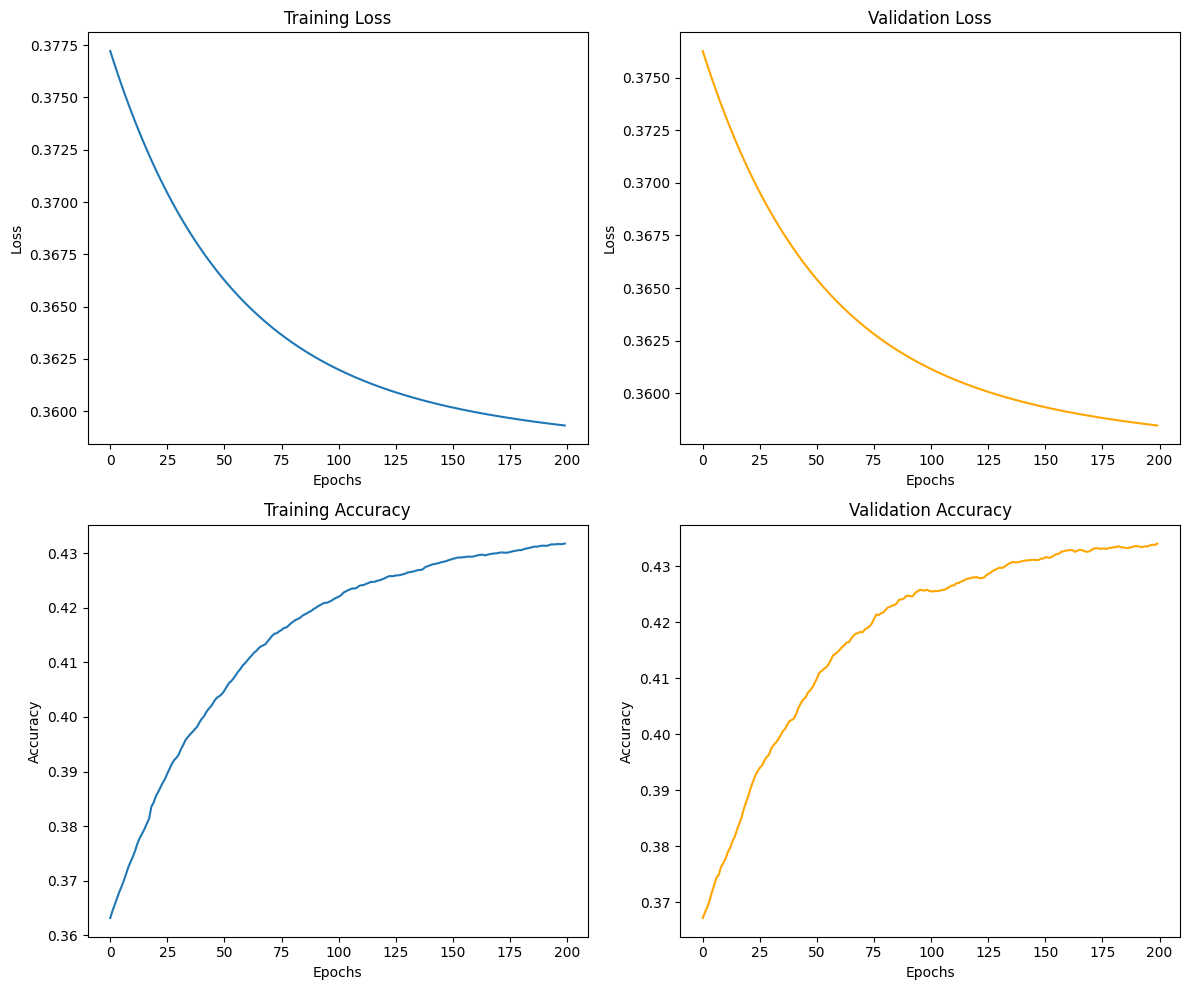

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epochs', ylabel='Loss', title='Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epochs', ylabel='Loss', title='Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy', title='Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy', title='Validation Accuracy')

plt.tight_layout()
plt.show()

**Đánh giá mô hình**

In [14]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print(f'Validation set accuracy: {val_set_acc:.4f}')
print(f'Test set accuracy: {test_set_acc:.4f}')

Validation set accuracy: 0.4340
Test set accuracy: 0.4323
